# Projeto de TCC
**Autor**: Igor Sousa dos Santos Santana

**Data**: 2024-07-26

## Índice

- [Importando pacotes e Bibliotecas](#importando-pacotes-e-bibliotecas)
- [Importando os Datasets](#importando-os-datasets)
- [Breve Apresentação dos Datasets](#breve-apresentacao-dos-datasets)
- [Análise Exploratória de Dados](#aed)
- [Preparação dos parâmetros](#preparando-os-hiper-parâmetros)
- [Algoritmo KMeans](#utilizando-o-algoritmo-kmeans)
- [Algoritmo MeanShift](#utilizando-o-algoritmo-meanshift)
- [Algoritmo FuzzyCMeans](#usando-o-algoritmo-fuzzycmeans)
- [Bibliografia](#bibliografia)

## Importando pacotes e Bibliotecas

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from fcmeans import FCM
import seaborn as sns
import pandas as pd
import numpy as np

## Importando os Datasets

In [2]:
df_iris_raw = pd.read_csv("./databases/raw/Iris.csv", sep = ",", index_col = "Id")

## Breve apresentacao dos datasets

In [3]:
df_iris_raw.sample(10)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
117,6.5,3.0,5.5,1.8,Iris-virginica
45,5.1,3.8,1.9,0.4,Iris-setosa
91,5.5,2.6,4.4,1.2,Iris-versicolor
55,6.5,2.8,4.6,1.5,Iris-versicolor
78,6.7,3.0,5.0,1.7,Iris-versicolor
30,4.7,3.2,1.6,0.2,Iris-setosa
72,6.1,2.8,4.0,1.3,Iris-versicolor
139,6.0,3.0,4.8,1.8,Iris-virginica


In [4]:
df_iris_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


## AED

In [5]:
df_frequencia_distribuicao_especies = pd.crosstab(index = df_iris_raw["Species"], columns = "quantidade")
df_frequencia_distribuicao_especies

col_0,quantidade
Species,
Iris-setosa,50
Iris-versicolor,50
Iris-virginica,50


### Separando as especies em datasets especificos

In [6]:
df_setosa = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-setosa"]
df_versicolor = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-versicolor"]
df_virginica = df_iris_raw.loc[df_iris_raw["Species"] == "Iris-virginica"]

### Imprimindo os gráficos

#### Histograma

<Figure size 2000x1200 with 0 Axes>

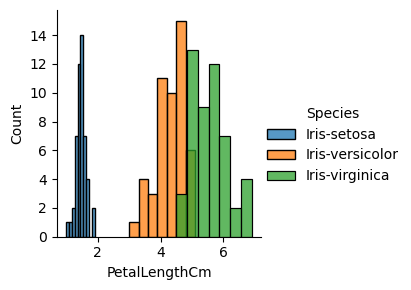

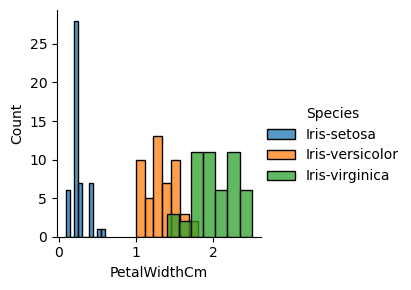

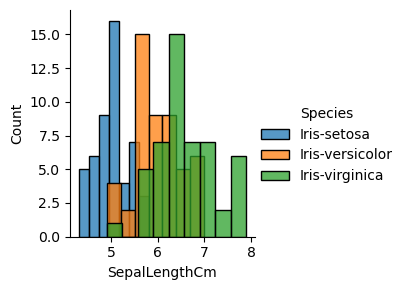

In [7]:
plt.figure(figsize = (20, 12))

sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "PetalLengthCm").add_legend()
sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "PetalWidthCm").add_legend()
sns.FacetGrid(df_iris_raw, hue = "Species", height = 3).map(sns.histplot, "SepalLengthCm").add_legend()

plt.show()

#### Boxplot

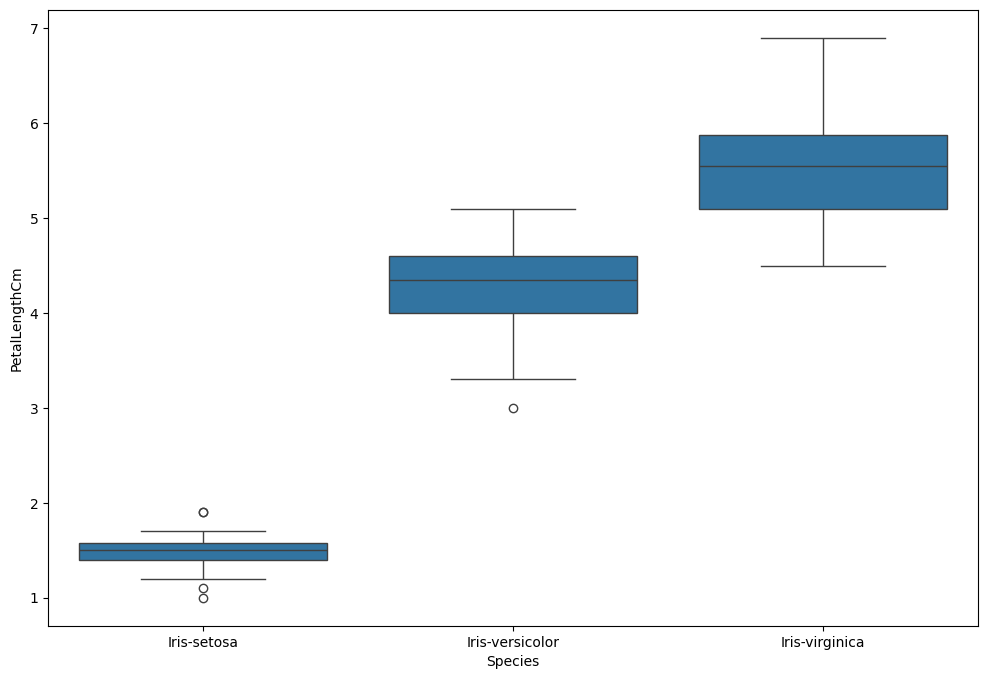

In [8]:
plt.figure(figsize = (12, 8))

sns.boxplot(data = df_iris_raw, x = "Species", y = "PetalLengthCm")

plt.show()

#### Violinplot

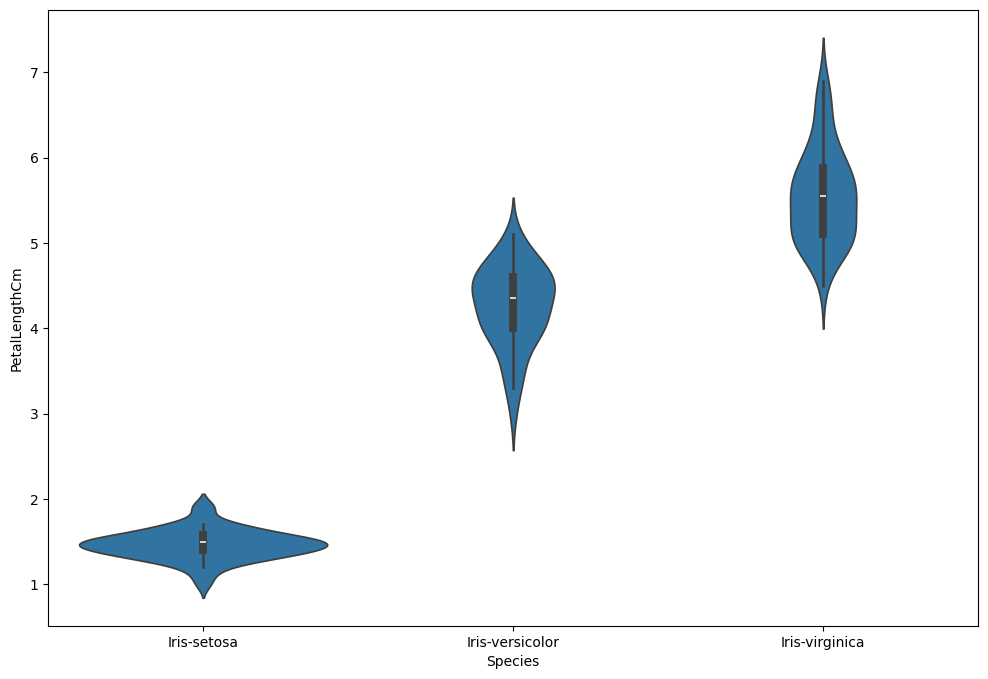

In [9]:
plt.figure(figsize = (12, 8))

sns.violinplot(data = df_iris_raw, x = "Species",y = "PetalLengthCm")

plt.show()

#### Gráfico de dispersão

<Figure size 2000x1200 with 0 Axes>

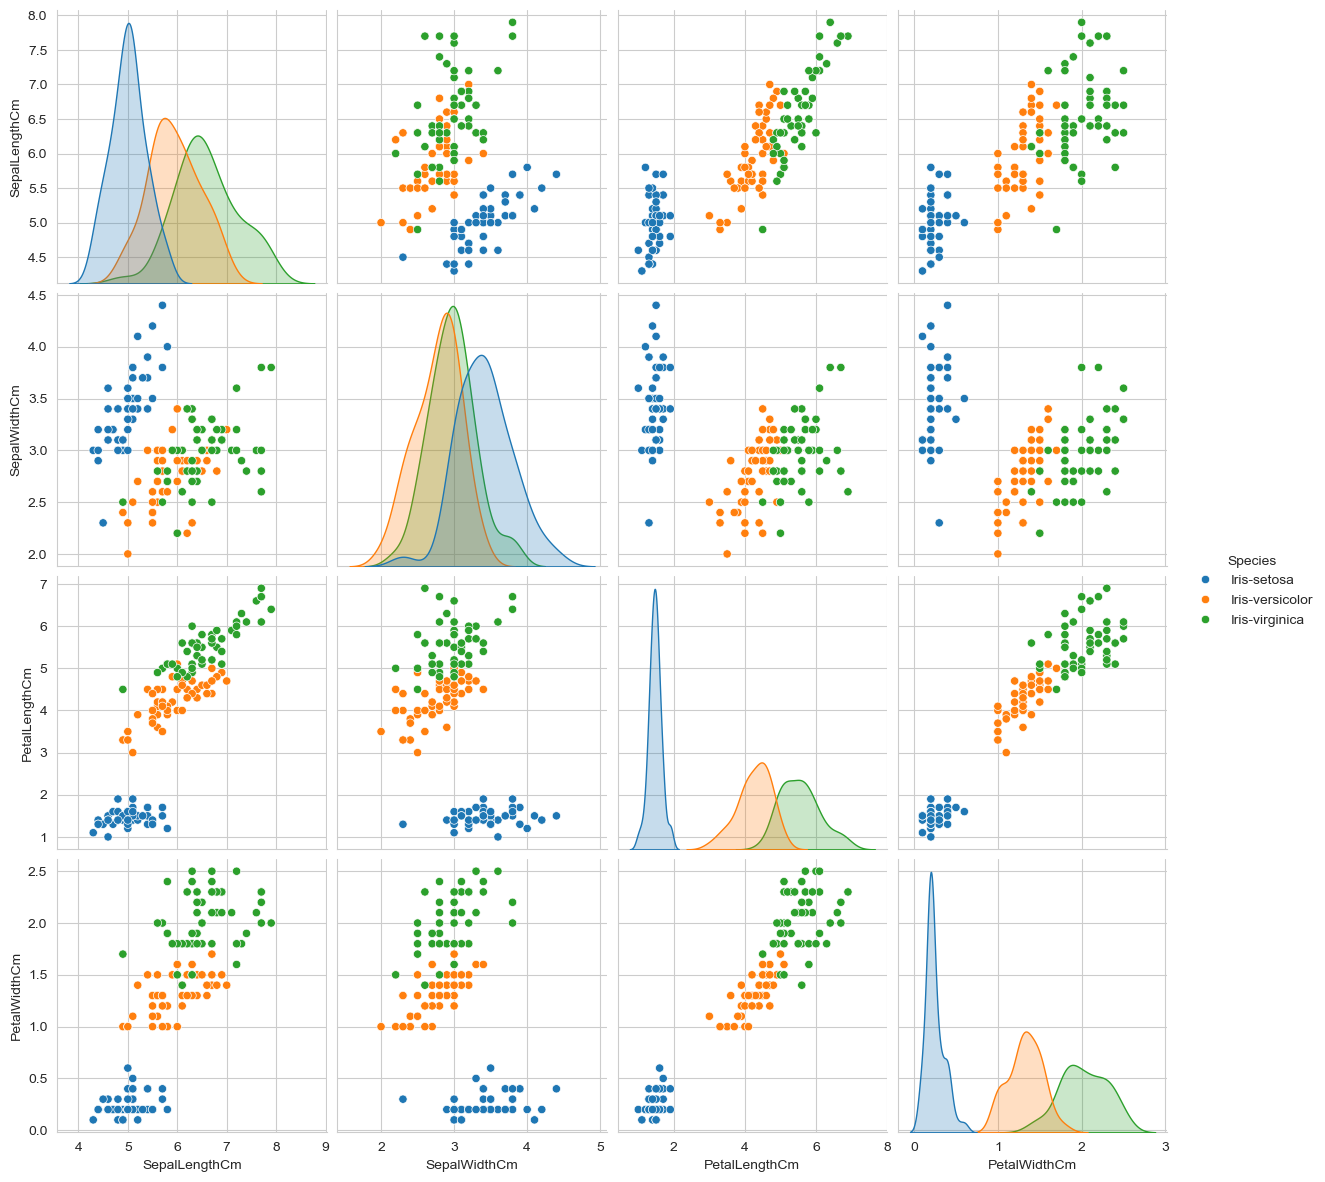

In [10]:
plt.figure(figsize = (20, 12))

sns.set_style("whitegrid")
sns.pairplot(df_iris_raw, hue = "Species", height = 3)

plt.show()

## Preparando os hiper parâmetros

In [11]:
X = df_iris_raw.drop(columns = ["Species"]).values
y = df_iris_raw["Species"]

In [12]:
nro_max_iteracoes = 300
nro_iteracoes_inicial = 10
semente_randomica = 42

## Utilizando o algoritmo Kmeans

In [13]:
soma_dos_quadrados = []

for i in range (1, 14):
    kmeans = KMeans(n_clusters = i,
                    init = "k-means++",
                    max_iter = nro_max_iteracoes,
                    n_init = nro_iteracoes_inicial,
                    random_state = semente_randomica)
    kmeans.fit(X)
    soma_dos_quadrados.append(kmeans.inertia_)

### Imprimindo o resultado dos testes

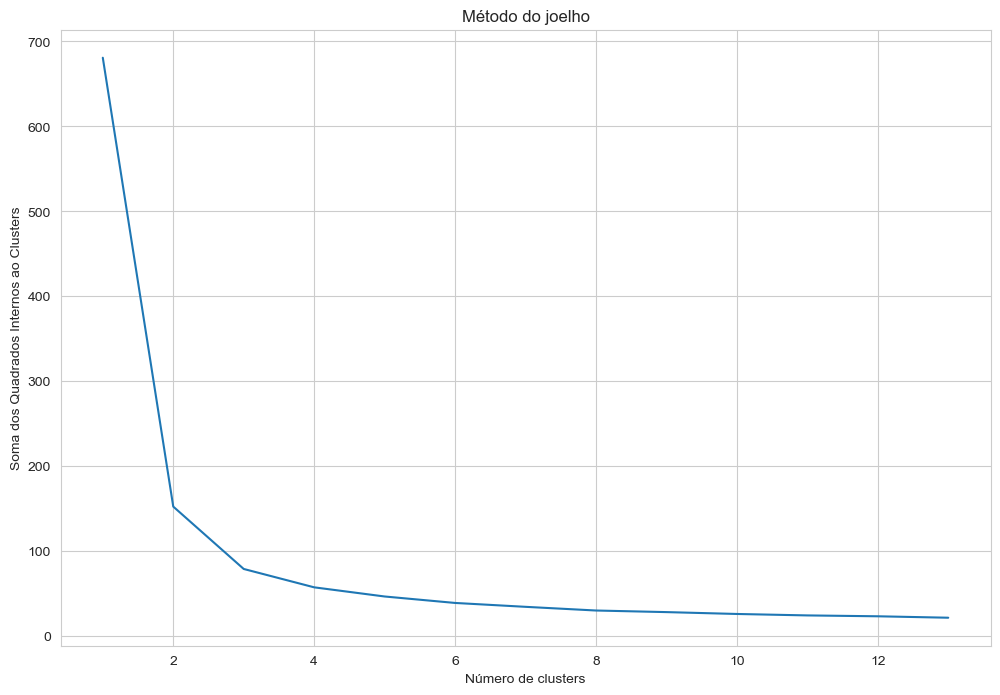

In [14]:
plt.figure(figsize = (12, 8))

plt.plot(range(1, 14), soma_dos_quadrados)
plt.title("Método do joelho")
plt.xlabel("Número de clusters")
plt.ylabel("Soma dos Quadrados Internos ao Clusters")

plt.show()

No caso acima, o resultado a partir do número 3 decai muito, portanto o número de clusters escolhido é 3

### Implementando a clusterização

In [15]:
kmeans = KMeans(n_clusters = 3,
                init = "k-means++",
                max_iter = nro_max_iteracoes,
                n_init = nro_iteracoes_inicial,
                random_state = semente_randomica)
y_kmeans = kmeans.fit_predict(X)

##### Visualizando os clusters

###### De forma 2D

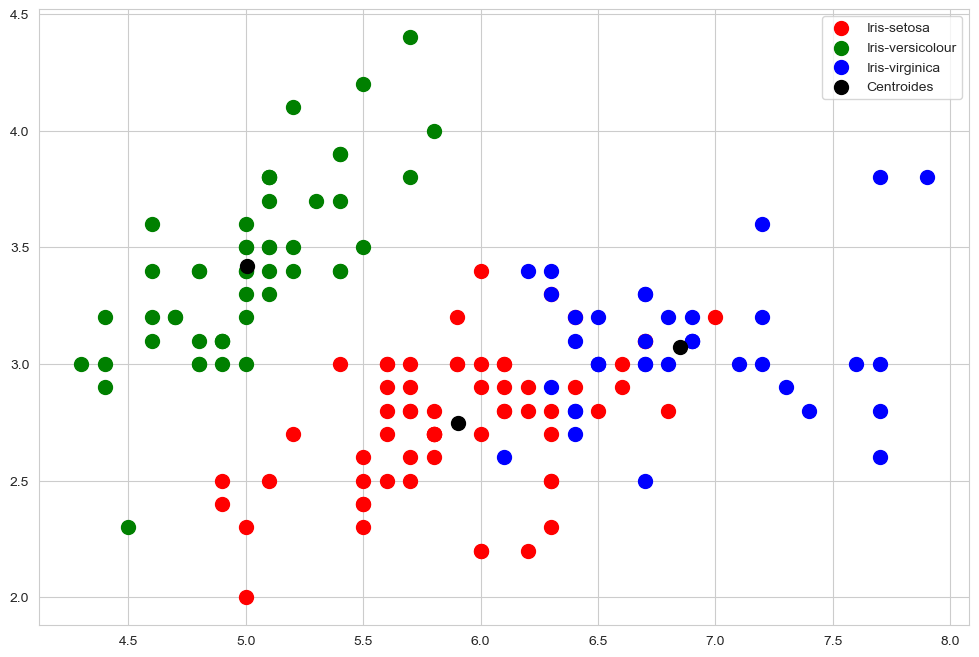

In [16]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

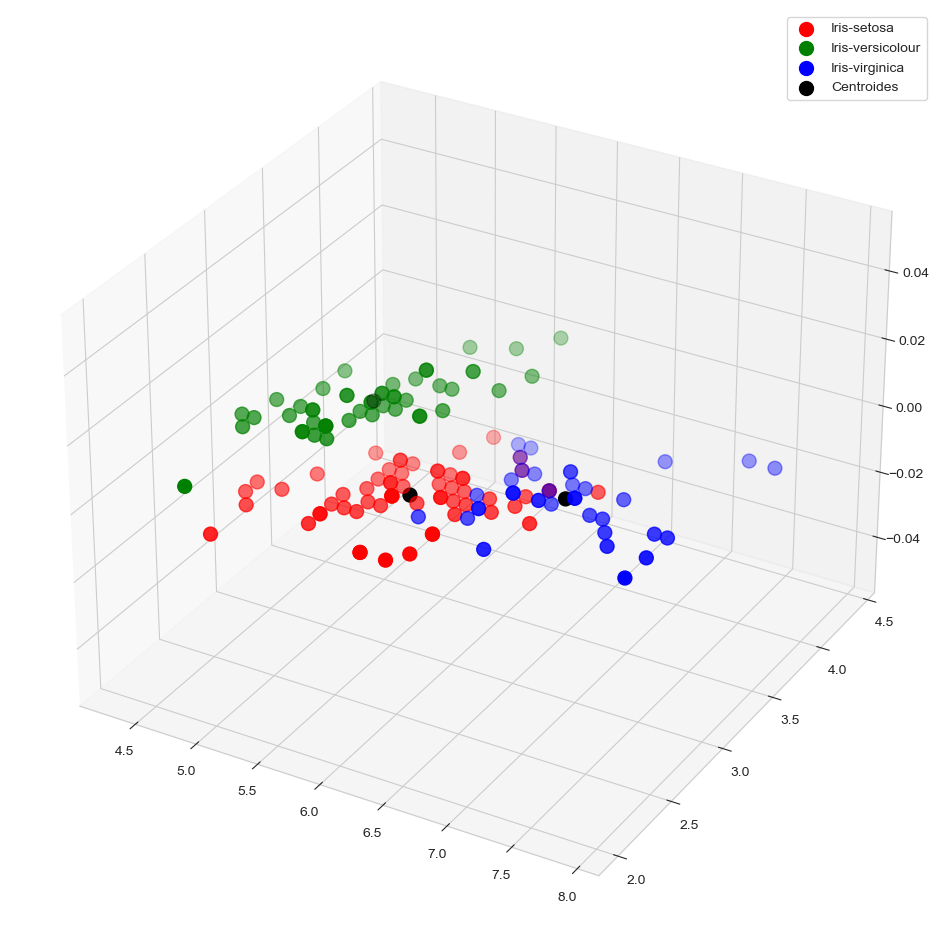

In [17]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Utilizando o algoritmo Meanshift

In [18]:
meanShift = MeanShift()
meanShift.fit(X)

labels = meanShift.labels_
centros = meanShift.cluster_centers_

### Visualizando os Resultados

In [19]:
nro_de_clusters = len(np.unique(labels))
print(f"Número estimado de clusters = {nro_de_clusters}", end = "\n")
print(f"Quantidade de labels = {len(centros)}", end = "\n")

Número estimado de clusters = 2
Quantidade de labels = 2


### Visualizando os resultados de forma gráfica

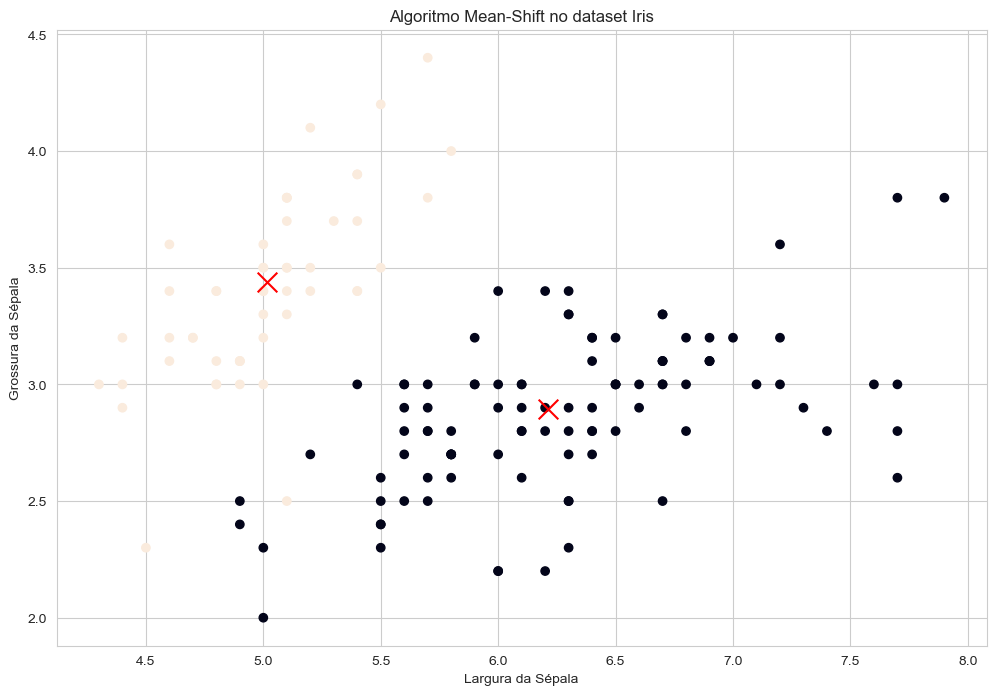

In [20]:
plt.figure(figsize = (12, 8))
plt.scatter(X[:, 0], X[:, 1], c = labels)
plt.scatter(centros[:, 0], centros[:, 1], marker = "x", color = "red", s = 200)
plt.xlabel("Largura da Sépala")
plt.ylabel("Grossura da Sépala")
plt.title("Algoritmo Mean-Shift no dataset Iris")
plt.show()

## Usando o algoritmo FuzzyCMeans

### Imprimindo o resultado dos testes

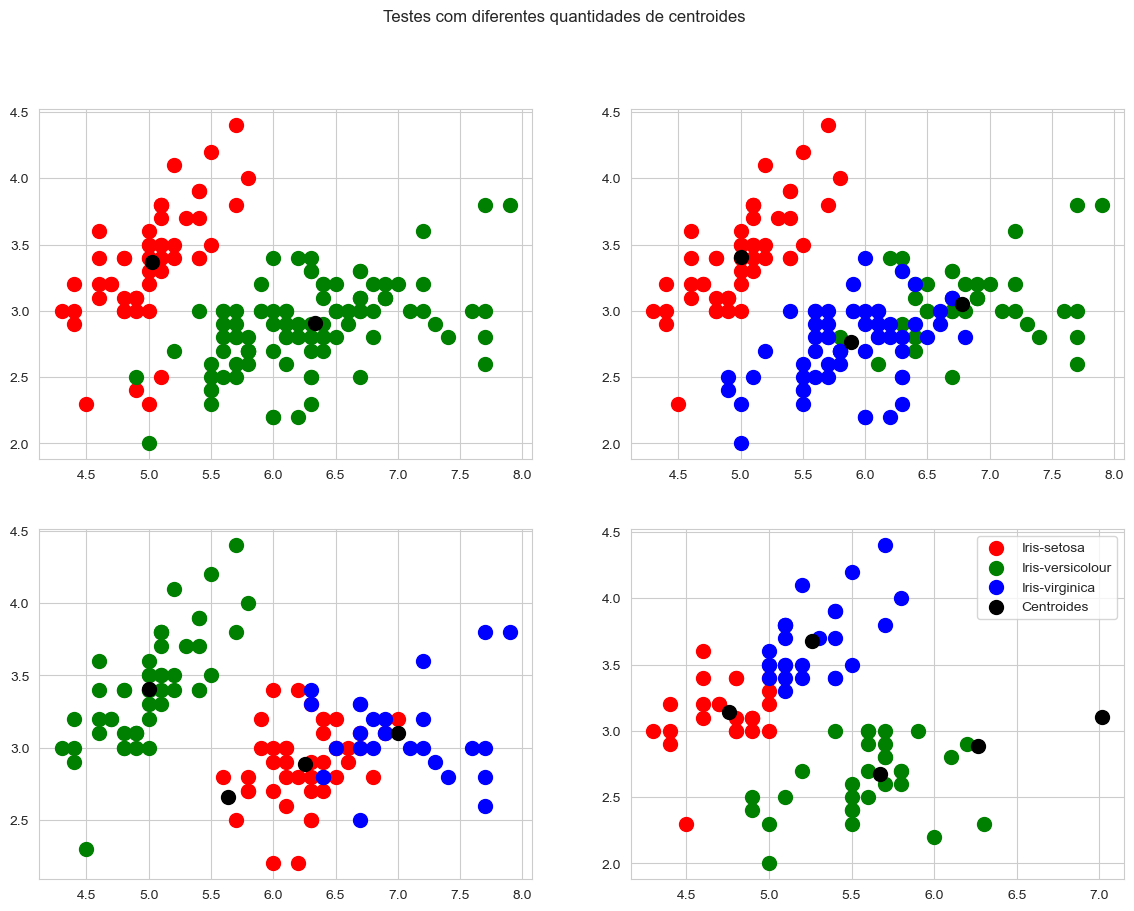

In [49]:
parametro_fuzzy = 2
figura, eixos = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 10))
j, k = 0, 0

for i in range (2, 6):
    cmeans = FCM(n_clusters = i,
                 m = parametro_fuzzy,
                 max_iter = nro_max_iteracoes,
                 n_init = nro_iteracoes_inicial,
                 random_state = semente_randomica)

    cmeans.fit(X)
    y_cmeans = cmeans.predict(X)
    centros = cmeans.centers
    
    
    ### OS PONTOS GERAIS
    eixos[j][k].scatter(X[y_cmeans == 0, 0], X[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
    eixos[j][k].scatter(X[y_cmeans == 1, 0], X[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
    eixos[j][k].scatter(X[y_cmeans == 2, 0], X[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

    ### OS CENTROIDES
    eixos[j][k].scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")
    
    k = (k - 1) * (-1)
    j = 1 if i > 2 else 0

plt.suptitle("Testes com diferentes quantidades de centroides")
plt.legend()
plt.show()

No caso acima, valor 3 é o que melhor descreve o conjunto dos pontos. Então será escolhido 3 como parâmetro para futuros testes no modelo

### Implementando a clusterização

In [53]:
parametro_fuzzy = 2
nro_de_clusters = 3

cmeans = FCM(n_clusters = nro_de_clusters,
             m = parametro_fuzzy,
             max_iter = nro_max_iteracoes,
             n_init = nro_iteracoes_inicial,
             random_state = semente_randomica)

cmeans.fit(X)
y_cmeans = cmeans.predict(X)
centros = cmeans.centers

##### Visualizando os clusters

###### De forma 2D

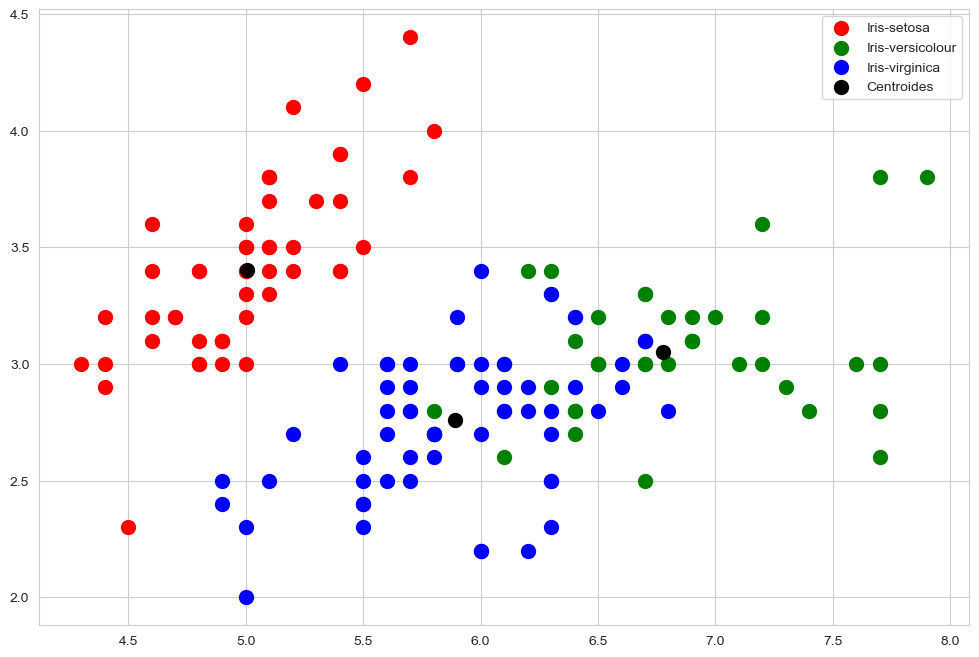

In [54]:
plt.figure(figsize = (12, 8))

### OS PONTOS GERAIS
plt.scatter(X[y_cmeans == 0, 0], X[y_cmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X[y_cmeans == 1, 0], X[y_cmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X[y_cmeans == 2, 0], X[y_cmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES

plt.scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

###### De forma 3D

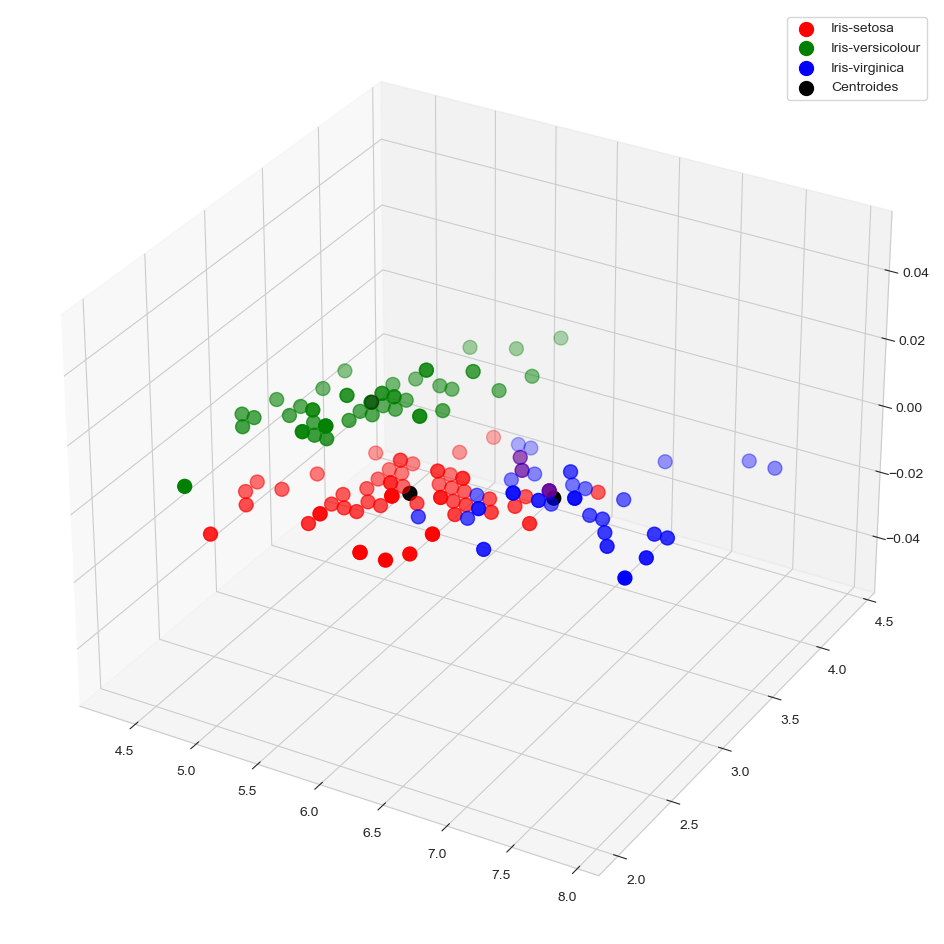

In [55]:
figura = plt.figure(figsize = (12, 12))
eixo = figura.add_subplot(111, projection = "3d")

### OS PONTOS GERAIS
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = "red", label = "Iris-setosa")
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = "green", label = "Iris-versicolour")
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = "blue", label = "Iris-virginica")

### OS CENTROIDES
plt.scatter(centros[:, 0], centros[:, 1], s = 100, c = "black", label = "Centroides")

plt.legend()
plt.show()

## Bibliografia

### SCIKIT-LEARN
- https://scikit-learn.org/stable/

### SCIKIT-LEARN.KMEANS
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### SCIKIT-LEARN.MEANSHIFT
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MeanShift.html
- https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

### FUZZY_C_MEANS
- https://pypi.org/project/fuzzy-c-means/
	- https://github.com/omadson/fuzzy-c-means
- https://github.com/ShristiK/Fuzzy-C-Means-Clustering
- https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
- https://www.kaggle.com/code/prateekk94/fuzzy-c-means-clustering-on-iris-dataset
- https://fda.readthedocs.io/en/latest/index.html
	- https://fda.readthedocs.io/en/latest/modules/ml/autosummary/skfda.ml.clustering.FuzzyCMeans.html
